# Introduction to control systems

Control theory is, in essence, a mathematical tool which allows us to control physical systems. The mathematics itself is rather abstract, but the physical implementation of control theory is incredibly intuitive once the understanding kicks in.

This short course will explore the theory and implementation of control using a practical and intuitive approach. We will attempt to bridge the gap between the abstract mathematics and the intuitive physical interpretation.

But to begin, why are we even interested in control theory at all?

## Motivation

Consider yourself an automotive engineer tasked with designing a cruise control system for a vehicle. A user must be able to set a desired speed for which the vehicle will maintain. We must be particularly careful to avoid going over the desired speed, as that may result in a speeding fine for the user, and potential liability and litigation for us!

### An early approach

One naive approach may be to preemptively measure the rolling resistance and torque loss due to the vehicle moving. We can measure how much torque a particular throttle signal yields. We can then simply calculate exactly how much throttle signal to apply to counteract the rolling friction, leading to equal and opposite torques and a constant speed. Surely this will work?

*What about when we go uphill?*

Here is where we run into the first (of many) issues with this approach. If the vehicle is going uphill, we lose additional torque and won't reach the desired speed. In addition, if we are going downhill, we may go over the desired speed and **break the law**.

There are many other problems with this approach, such as but not limited to:
- What if there are more people in the vehicle, causing it to weigh more?
- What if the vehicle is pulling a trailer, losing significant torque?
- What if the tyres start going flat, increasing rolling resistance?
- What if heavy winds are present, causing additional external forces on the vehicle?
- What happens as the vehicle ages, or if a different fuel is used?

As you can see, this early approach has many problems, and a more robust solution is necessary.

### A more effective solution

Let's try something else: Instead of preemptively measuring data and hoping it works, why don't we simply measure the vehicle velocity in real time and make adjustments to the throttle signal based on the current velocity? Let's take the desired velocity, and subtract the actual velocity; i.e. *how far are we from where we want to be?* This is known as the *error signal* $e$. Then, we can multiply this error signal by some constant $K>0$ and apply that to the throttle. Thus we get the following conditions:

- If we are slower than we desire, the error signal will be positive, giving a throttle signal $Ke>0$ and the vehicle accelerating.
- If we are almost at the speed we want, but still a bit slow, $e$ is small $\implies$ the throttle signal $Ke$ is relatively small, and only a small amount of acceleration is given.
- If we are travelling at exactly the speed we want, $e=0$ leading to a throttle signal of $Ke=0$ and no acceleration.
- If we are faster than we want, $e<0$ and our throttle signal is negative, implying we will brake and slow down.

This example is known as a *Proportional controller*, since the output signal (throttle in this case) is *proportional* to the error signal. It can be visualised with a block diagram, shown below.

![Image](./images/P_controller.svg)

Let's now simulate the above example.

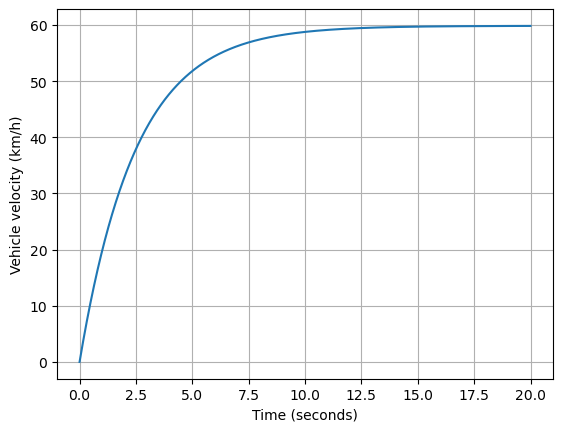

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a time array
dt = 0.001
t = np.arange(0,20,dt)

# Set up mass and damping
# We'll assume the force on the vehicle is F = m*a + b*v + throttleSignal
m = 1000
b = 1 # Loss due to air resistance, rolling resistance, etc.

# Setpoint and initial velocity/acceleration
sp = 60
v = np.zeros(np.size(t)+1)
v[0] = 0 # Can set whichever initial velocity is desired
a = 0

# Proportional gain
K = 400

# Iterate along the time array
for i in range(np.size(t)):
    e = sp - v[i]
    throttleSignal = K * e
    
    # Update parameters
    Floss = b*v[i]
    Ftot = throttleSignal - Floss
    a = Ftot / m
    v[i+1] = v[i] + a*dt

# Plot resulting velocity
plt.plot(t,v[:np.size(t)])
plt.ylabel('Vehicle velocity (km/h)')
plt.xlabel('Time (seconds)')
plt.grid()

As we can see from above, the controller does a pretty good job at getting us to the desired speed. For a number of simple systems, a simple proportional controller is acceptable, but for more complicated systems a more in depth approach is needed.

### Another example

Consider a joint in a robotic arm which is able to apply torque with some electric motor. We can model this system similarly to above; the arm has a moment of inertia and some damping due to friction and will roughly follow the equation

$$ J\ddot\theta + b\dot\theta = \tau \text{.} $$

Assuming we can accurately measure the angle $\theta$ of the arm in real time, we can apply a proportional controller as above.

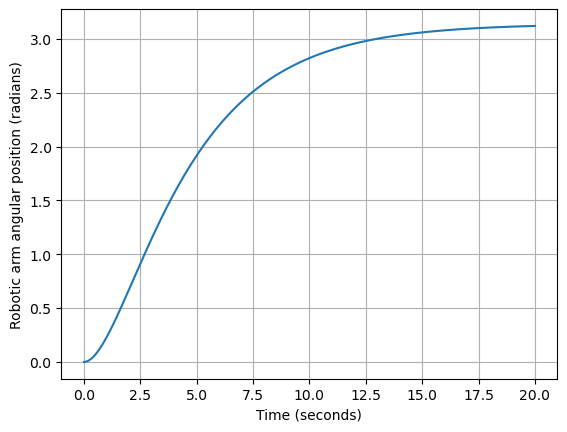

In [2]:
# Use the same libraries and time vector as above; no need to re-import and re-initialise

# Set up moment of inertia and damping
J = 1
b = 1

# Setpoint and initial angular position/velocity/acceleration
sp = np.pi
theta = np.zeros(np.size(t)+1)
theta[0] = 0 # Can set whichever initial angular position is desired
thetadot = 0
thetadotdot = 0

# Proportional gain
K = 0.2

# Iterate along the time array
for i in range(np.size(t)):
    e = sp - theta[i]
    motorTorque = K * e
    
    # Update parameters
    tLoss = b*thetadot
    tTot = motorTorque - tLoss
    thetadotdot = tTot / J
    theta[i+1] = theta[i] + thetadot*dt
    thetadot = thetadot + thetadotdot*dt

# Plot resulting angular position
plt.plot(t,theta[:np.size(t)])
plt.ylabel('Robotic arm angular position (radians)')
plt.xlabel('Time (seconds)')
plt.grid()

Similarly to earlier, we are seeing the motor move to the desired position, decelerating as it becomes closer to the setpoint. What if we try to improve this controller, by, say, increasing the gain? Surely that would make the system approach the setpoint faster, as we're effectively giving the motor access to more torque. Let's explore this with a gain of $K=10$.

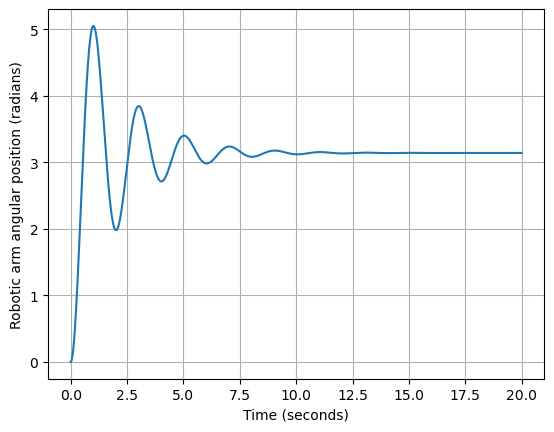

In [3]:
# Proportional gain
K = 10 # Increase the gain to 10

# Iterate along the time array
for i in range(np.size(t)):
    e = sp - theta[i]
    motorTorque = K * e
    
    # Update parameters
    tLoss = b*thetadot
    tTot = motorTorque - tLoss
    thetadotdot = tTot / J
    theta[i+1] = theta[i] + thetadot*dt
    thetadot = thetadot + thetadotdot*dt

# Plot resulting angular position
plt.plot(t,theta[:np.size(t)])
plt.ylabel('Robotic arm angular position (radians)')
plt.xlabel('Time (seconds)')
plt.grid()

Here we encounter *overshoot* and *oscillation*, some of the common challenges faced in control theory. The inertia of the robotic arm is carrying the arm beyond the setpoint, before the controller reacts and brings it back. In some cases, this is acceptable, and sometimes even desired to some extent. However, in our previous example of a cruise control system, this is unacceptable. However, we do notice that the system achieves close to setpoint much faster (~8 seconds as opposed to ~12seconds). Though the oscillation is not great. Let's iterate again with a gain value somewhere between.

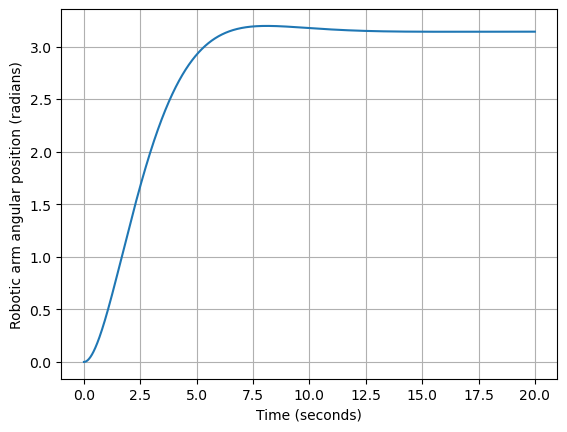

In [4]:
# Proportional gain
K = 0.4

# Iterate along the time array
for i in range(np.size(t)):
    e = sp - theta[i]
    motorTorque = K * e
    
    # Update parameters
    tLoss = b*thetadot
    tTot = motorTorque - tLoss
    thetadotdot = tTot / J
    theta[i+1] = theta[i] + thetadot*dt
    thetadot = thetadot + thetadotdot*dt

# Plot resulting angular position
plt.plot(t,theta[:np.size(t)])
plt.ylabel('Robotic arm angular position (radians)')
plt.xlabel('Time (seconds)')
plt.grid()

Here, we've found a pretty good spot. We technically have a small overshoot, but it's insignificant. In addition, we've considerably reduced the *settling time* to roughly 6seconds.

### Conclusion

In this section, we've introduced control systems and basic proportional control in the time domain. We've seen the introduction of overshoot and oscillation, as well as an iterative example demonstrating the benefit of such iterative designs. We'll soon move on to using a more robust mathematical construct to analyse these systems, before exploring more effective control schemes.